# **Tarea de programacion Introduction to Deep Learning HSE Semana 1**
Javier Alejandro Ortiz Silva

# Programming assignment (Linear models, Optimization)

In this programming assignment you will implement a linear classifier and train it using stochastic gradient descent modifications and numpy.

In [224]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week2_honor()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

--2021-05-02 10:37:23--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2021-05-02 10:37:23 (39.2 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]



In [225]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [226]:
import sys
sys.path.append("..")
import grading
grader = grading.Grader(assignment_key="UaHtvpEFEee0XQ6wjK-hZg", 
                      all_parts=["xU7U4", "HyTF6", "uNidL", "ToK7N", "GBdgZ", "dLdHG"])

In [227]:
# token expires every 30 min
COURSERA_TOKEN = "6E2qQcMLhFHFRmhD" 
### YOUR TOKEN HERE

COURSERA_EMAIL = "jortizsi@unal.edu.co"
### YOUR EMAIL HERE

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with synthetic data.

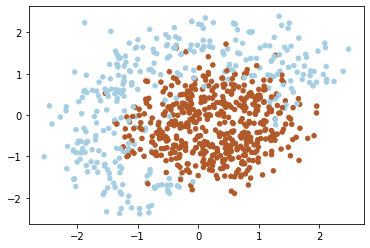

In [228]:
with open('train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('target.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

# Task

## Features

As you can notice the data above isn't linearly separable. Since that we should add features (or use non-linear model). Note that decision line between two classes have form of circle, since that we can add quadratic features to make the problem linearly separable. The idea under this displayed on image below:

![](https://github.com/hse-aml/intro-to-dl/blob/master/week1/kernel.png?raw=1)

***Funcion expand***

Con dos features las entradas matriz son de la siguiente forma
\begin{matrix}
\\
[feature0_1,feature1_1]\\
...\\
[feature0_n,feature1_n]
\end{matrix}

Queremos obtener
\begin{matrix}
\\
[feature0_1, feature1_1, (feature0_1)^2, (feature1_1)^2, feature0_1*feature1_1, 1]\\
...\\
[feature0_n, feature1_n, (feature0_n)^2, (feature1_n)^2, feature0_n*feature1_n, 1]
\end{matrix}



In [229]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6)) #matriz para rellenar
    
    # TODO:<your code here>

    numero_de_filas = X.shape[0]
    for i in range(numero_de_filas): #en cada fila de la matriz llenar los valores segun la formula dada

      feature_0 = X[i][0]
      feature_1 = X[i][1]

      X_expanded[i][0] = feature_0
      X_expanded[i][1] = feature_1
      X_expanded[i][2] = feature_0**2
      X_expanded[i][3] = feature_1**2
      X_expanded[i][4] = feature_0 * feature_1
      X_expanded[i][5] = 1

    return X_expanded

In [230]:
X_expanded = expand(X)
print(expand(dummy_X))

[[ 0.      0.      0.      0.      0.      1.    ]
 [ 1.      0.      1.      0.      0.      1.    ]
 [ 2.61   -1.28    6.8121  1.6384 -3.3408  1.    ]
 [-0.59    2.1     0.3481  4.41   -1.239   1.    ]]


Here are some tests for your implementation of `expand` function.

In [231]:
# simple test on random numbers

dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

# call your expand function
dummy_expanded = expand(dummy_X)

# what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape == dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")


Seems legit!


## Logistic regression

To classify objects we will obtain probability of object belongs to class '1'. To predict probability we will use output of linear model and logistic function:

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [232]:
def probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    Don't forget to use expand(X) function (where necessary) in this and subsequent functions.
    
    :param X: feature matrix X of shape [n_samples,6] (expanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """

    # TODO:<your code here>
    numero_de_samples = X.shape[0] 
    respuesta = np.zeros(numero_de_samples) #Arreglo para llenar con las probabilidades
    for i in range(numero_de_samples):
     respuesta[i] = 1 / (   1 + np.exp(-np.dot(w,X[i]))   ) #calculo de la formula dada con el w fijo y un sample x i

    return respuesta

In [233]:
#Ejemplo para prueba
dummy_weights = np.linspace(-1, 1, 6)
ans_part1 = probability(X_expanded[:1, :], dummy_weights)[0]
print("vector w pesos: ", dummy_weights)
print("matriz de features: ",X_expanded[:1, :])
print("probabilidad de y=1: ",ans_part1)

vector w pesos:  [-1.  -0.6 -0.2  0.2  0.6  1. ]
matriz de features:  [[1.20798057 0.0844994  1.45921706 0.00714015 0.10207364 1.        ]]
probabilidad de y=1:  0.3803998509843769


In [234]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("xU7U4", ans_part1)

In [235]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In logistic regression the optimal parameters $w$ are found by cross-entropy minimization:

Loss for one sample: $$ l(x_i, y_i, w) = - \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1\, | \, x_i,w))}\right] $$

Loss for many samples: $$ L(X, \vec{y}, w) =  {1 \over \ell} \sum_{i=1}^\ell l(x_i, y_i, w) $$



In [236]:
#funcion l con parametros yi y P, en vez de xi,yi y w, porque calcular P es facil 
#con los desarrollos anteriores de este lab
def perdida_1_sample(yi,P):
  return -((yi * np.log(P)) + (1-yi)*np.log(1-P))


def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute scalar loss function L using formula above.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    # TODO:<your code here>
    probabilidades = probability(X,w) #calculo de P(yi=1 | xi,w) para cada fila-sample
    acumulador = 0
    numero_de_samples = X.shape[0] 
    for i in range(numero_de_samples):
      acumulador += perdida_1_sample(y[i],probabilidades[i]) #calculo de la funcion l con la formula dada

    return acumulador/numero_de_samples #promedio despues de haber hecho la sumatoria


In [237]:
# use output of this cell to fill answer field 
ans_part2 = compute_loss(X_expanded, y, dummy_weights)
print(ans_part2)

1.0185634030782509


In [238]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("HyTF6", ans_part2)

In [239]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


Since we train our model with gradient descent, we should compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \nabla_w l(x_i, y_i, w) $$ 

We won't be giving you the exact formula this time — instead, try figuring out a derivative with pen and paper. 

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how $L$ changes if you shift $w$ by $10^{-5}$ or so).

#**Determinacion del gradiente**#

Sabiendo que la formula de la funcion de perdida esta en forma de constantes multiplicadas por expresiones de la forma Log(1/1+e^-<x,w>) y Log(1 - 1/1+e^-<x,w>), para obtener la ecuacion del gradiente nos importa principalmente derivar estas secciones de la funcion de perdida. Esto lo realizamos en este caso uilizando la app PhotoMath. Para la parte <x,w> ingresamos un caso ax+by+cz y a partir de ahi obtenemos informacion.

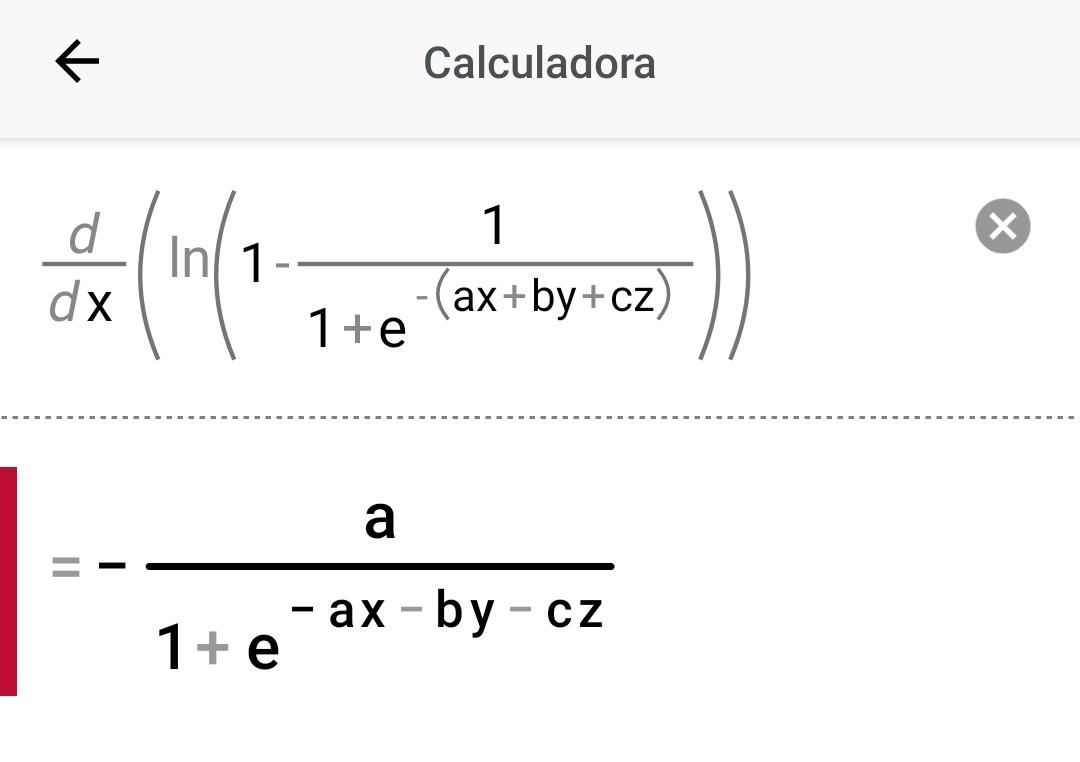

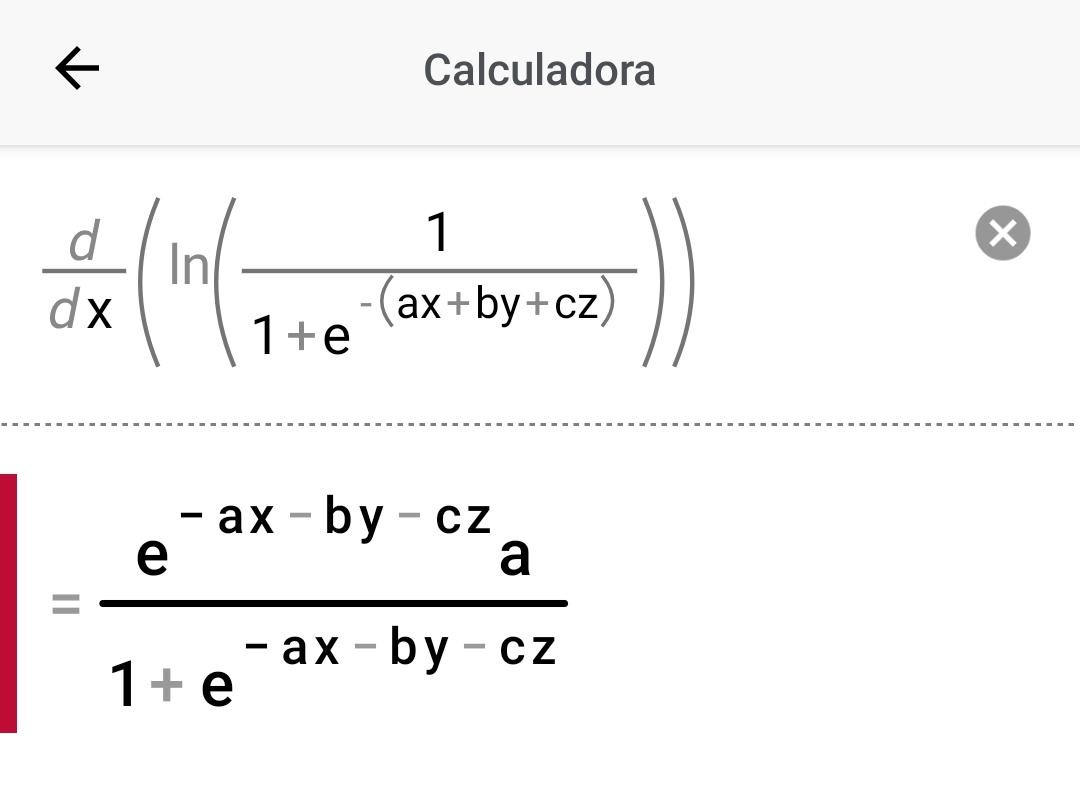

En las derivadas parciales respecto a $w_i$ la unica diferencia esta en una constante que corresponde al valor en el vector x que se empareja con el peso $w_i$ de la variable a diferenciar. Con estos resultados y teniendo en cuenta la funcion de perdida original podemos codificar las derivadas parciales y con ellas el gradiente.

In [240]:
def derivada_funcion_de_perdida(yi,xi,w,variable): #Derivada parcial evaluada en valores dados
  c = xi[variable]
  menos_producto_punto_x_w = -np.dot(w,xi)
  dLogP = (np.exp(menos_producto_punto_x_w)*c) / ( 1 + np.exp(menos_producto_punto_x_w) )
  dLog_1_menos_P = -c/( 1 + np.exp(menos_producto_punto_x_w) )
  return -((yi * dLogP ) + (1-yi)*dLog_1_menos_P)


def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    
    # TODO<your code here>
    numero_de_samples = X.shape[0] 
    respuesta = np.zeros(6) #Arreglo para llenar

    for i in range(numero_de_samples):  #Ir acumulando los valores de derivadas parciales para cada variable usando cada caso dado
      respuesta[0] += derivada_funcion_de_perdida(y[i],X[i],w,0) #d w_0
      respuesta[1] += derivada_funcion_de_perdida(y[i],X[i],w,1)
      respuesta[2] += derivada_funcion_de_perdida(y[i],X[i],w,2)
      respuesta[3] += derivada_funcion_de_perdida(y[i],X[i],w,3) #...
      respuesta[4] += derivada_funcion_de_perdida(y[i],X[i],w,4)
      respuesta[5] += derivada_funcion_de_perdida(y[i],X[i],w,5) #d w_5

    return respuesta/numero_de_samples #obtener promedios y devolver el vector gradiente calculado

In [241]:
# use output of this cell to fill answer field 
ans_part3 = np.linalg.norm(compute_grad(X_expanded, y, dummy_weights))
print(compute_grad(X_expanded, y, dummy_weights))

[-0.32741296  0.05429288  0.31961242  0.38946883  0.2029897   0.06801579]


In [242]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("uNidL", ans_part3)
print(ans_part3)

0.6401687302118626


In [243]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


Here's an auxiliary function that visualizes the predictions:

In [244]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

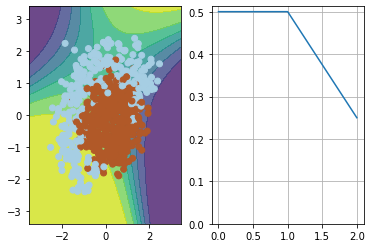

In [245]:
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Training
In this section we'll use the functions you wrote to train our classifier using stochastic gradient descent.

You can try change hyperparameters like batch size, learning rate and so on to find the best one, but use our hyperparameters when fill answers.

## Mini-batch SGD

Stochastic gradient descent just takes a random batch of $m$ samples on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$



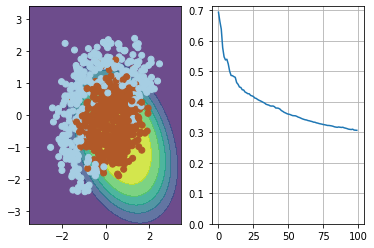

<Figure size 432x288 with 0 Axes>

In [246]:
# please use np.random.seed(42), eta=0.1, n_iter=100 and batch_size=4 for deterministic results

np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # Keep in mind that compute_grad already does averaging over batch for you!
    # TODO:<your code here>

    w = w - eta * compute_grad(X_expanded[ind, :], y[ind], w) #Actualizar w_t en la iteracion actual utilizando el gradiente resultado de los casos elegidos al azar
visualize(X, y, w, loss)
plt.clf()

In [247]:
# use output of this cell to fill answer field 

ans_part4 = compute_loss(X_expanded, y, w) #w fue ajustada en la celda anterior
print(ans_part4)

0.3042764698992405


In [248]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("ToK7N", ans_part4)

In [249]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## SGD with momentum

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations as can be seen in image below. It does this by adding a fraction $\alpha$ of the update vector of the past time step to the current update vector.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>


![](https://github.com/hse-aml/intro-to-dl/blob/master/week1/sgd.png?raw=1)


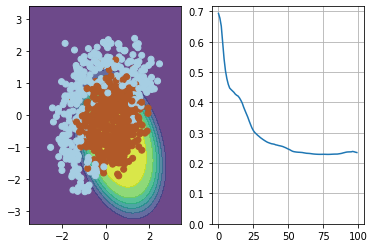

<Figure size 432x288 with 0 Axes>

In [250]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # TODO:<your code here>
    nu = (alpha * nu) + (eta * compute_grad(X_expanded[ind, :], y[ind], w)) #recalcular el vector de actualizacion nu   #nu es una letra griega cuya minuscula parece una v
    w = w - nu #actualizar w_t

visualize(X, y, w, loss)
plt.clf()

In [251]:
# use output of this cell to fill answer field 

ans_part5 = compute_loss(X_expanded, y, w)
print(ans_part5) #Este valor es menor que la ultima vez que se imprimio para minibatch sgd. Los valores asignados a w son mas adecuados.

0.23245916420113058


In [252]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("GBdgZ", ans_part5)

In [253]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## RMSprop

Implement RMSPROP algorithm, which use squared gradients to adjust learning rate:

$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$
$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$

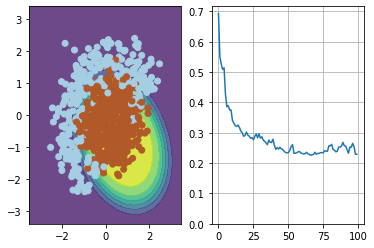

<Figure size 432x288 with 0 Axes>

In [254]:
# please use np.random.seed(42), eta=0.1, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 # learning rate
alpha = 0.9 # moving average of gradient norm squared
g2 = None # we start with None so that you can update this value correctly on the first iteration
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)


G = 0 #G cumple una funcion de acumulador del comportamiento de los gradientes cuadrados pasados 

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # TODO:<your code here>
    
    g = compute_grad(X_expanded[ind, :], y[ind], w) #vector gradiente
    g2 = g**2 #gradiente cuadrado
    
                     
    G = alpha*G + (1-alpha)*g2 # actualizar G
    w = w - ( ( eta/(np.sqrt(G + eps)) ) * g ) # actualizar w

visualize(X, y, w, loss)
plt.clf()

In [255]:
# use output of this cell to fill answer field 
ans_part6 = compute_loss(X_expanded, y, w)
print(ans_part6) # un poco mejor que el SGD con momentum

0.22383829902910232


In [256]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("dLdHG", ans_part6)

In [257]:
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
